In [1]:
# system
import time
import os

# tools
import argparse
import json
import pandas as pd
from itertools import product
from lib.util.mio import gdfR

# computation libs
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy.linalg

# plot
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
import matplotlib.pyplot as plt
import figurefirst as fifi

# Auto Reloading
%load_ext autoreload
%autoreload 2

In [2]:
# figure setting
figrect = (2.5, 2)
figsquare = (3.0, 3.0)

rasterflag = False

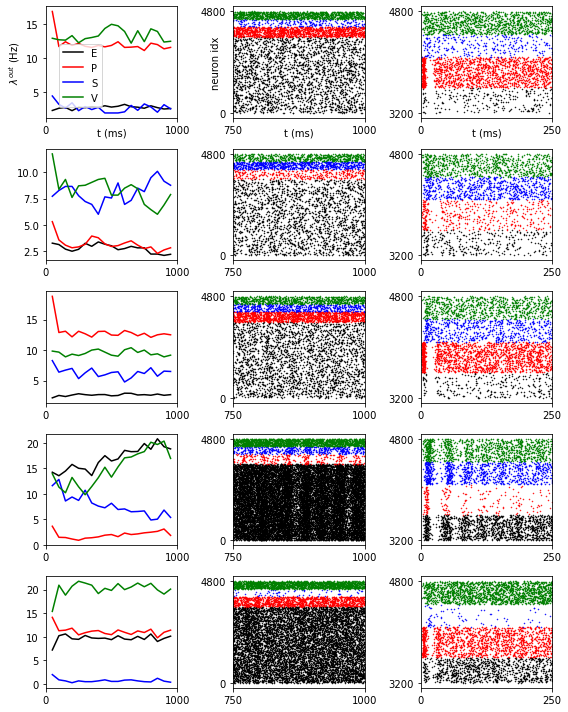

In [4]:
# Baseline and raster plot
J, m, r = 25.0, 0.5, 0.0
datapath = './data/J%.1f-m%.1f-r%.1f/'%(J, m, r)

# load recording
modE, modP, modS, modV = 0., 0., 0., 0.
affix = 'E%.1fP%.1fS%.1fV%.1f'%(modE, modP, modS, modV)
with open(datapath + affix + '/set.json', 'r') as net_fp:
    motif_set = json.loads(net_fp.read())
nrn_tps, nrn_cnt, simts = motif_set[0], motif_set[1], motif_set[2]
warmup, simtime = simts

T = np.sum(simts)

binsize = 50.
id_bins = np.concatenate([[0], np.cumsum(nrn_cnt)]) + 1
ts_bins = np.arange(0, warmup + simtime, binsize)
tbounds = [0., 250.]

epsvs = ['E-0.1P0.0S0.0V0.0', 'E-0.6P-30.0S1.8V0.0', 'E2.2P13.2S1.4V0.0', 'E6.0P-45.0S0.0V0.0', 'E3.2P-12.0S-2.4V0.0']

cs = ['k', 'r', 'b', 'g']
plt.subplots(figsize=(8, 2*len(epsvs)))
for fidx, affix in enumerate(epsvs):
    rec = gdfR(datapath + affix + '/')
    ts, es = rec[0], rec[1]
    fr_2d = np.histogram2d(ts, es, bins=[ts_bins, id_bins])[0]
    rates = fr_2d*1e3/binsize/nrn_cnt

    plt.subplot(len(epsvs),3,1+3*fidx)
    for idx, label in enumerate(['E', 'P', 'S', 'V']):
        plt.plot(ts_bins[1:], rates[:,idx], c=cs[idx], label=label)
    plt.xticks([0., T])
    if fidx == 0:
        plt.xlabel('t (ms)', labelpad=-7)
        plt.ylabel(r'$\lambda^{out}$ (Hz)')
        plt.legend(loc=[0.1,0.1] ,fontsize='medium')

    ps = np.concatenate([[0], np.cumsum(nrn_cnt)])
    plt.subplot(len(epsvs),3,2+3*fidx)
    for lb, hb, c in zip(ps[:-1], ps[1:], cs):
        mask = (es >= lb) & (es < hb)
        plt.scatter(ts[mask], es[mask], c=c, s=1, marker='.')
    plt.xticks([T-tbounds[-1], T])
    plt.xlim([T-tbounds[-1], T])
    plt.yticks([ps[0], ps[-1]])
    if fidx == 0:
        plt.xlabel('t (ms)', labelpad=-7)
        plt.ylabel('neuron idx', labelpad=-20)

    ps = np.concatenate([[3200], np.cumsum(nrn_cnt)])
    plt.subplot(len(epsvs),3,3+3*fidx)
    for lb, hb, c in zip(ps[:-1], ps[1:], cs):
        mask = (es >= lb) & (es < hb)
        plt.scatter(ts[mask], es[mask], c=c, s=1, marker='.')
    plt.xticks(tbounds)
    plt.xlim(tbounds)
    plt.yticks([ps[0], ps[-1]])
    if fidx == 0:
        plt.xlabel('t (ms)', labelpad=-7)

plt.tight_layout()
plt.savefig('./plot/ratespike.pdf', dpi=100)